[*********************100%***********************]  2 of 2 completed


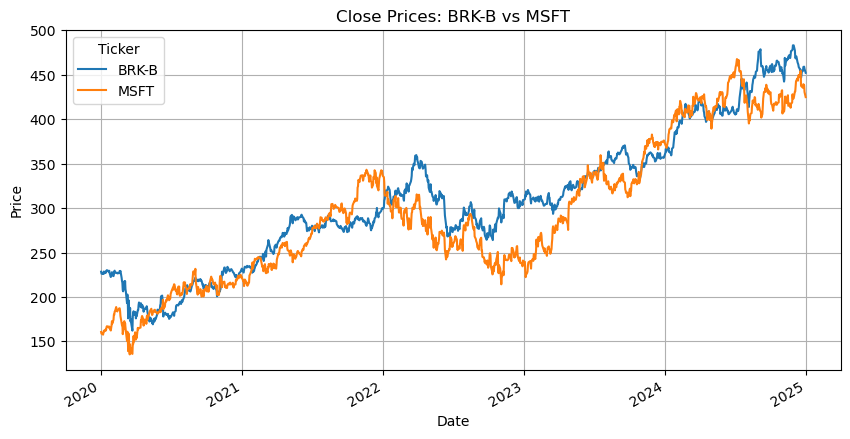

In [51]:
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

# define tickers and time frame
tickers = ['BRK-B', 'MSFT']
start_date = '2020-01-01'
end_date = '2024-12-31'

# close prices for stocks
data = yf.download(tickers, start=start_date, end=end_date, auto_adjust=False)['Close']
data.dropna(inplace=True)

# plot prices
data.plot(title="Close Prices: BRK-B vs MSFT", figsize=(10, 5))
plt.ylabel("Price")
plt.xlabel("Date")
plt.grid()
plt.show()

# save to CSV
data.to_csv('../data/brkb_msft_prices.csv')


In [47]:
from statsmodels.tsa.stattools import coint

# Cointegration test: determining if spread between two assets are constant
# Null hypothesis: spread is non-stationary
score, pvalue, _ = coint(data['BRK-B'], data['MSFT'])

# We want a p val < 0.05 ideally, which means conintegration exists
print(f"Cointegration p-value: {pvalue:.4f}")


Cointegration p-value: 0.1096


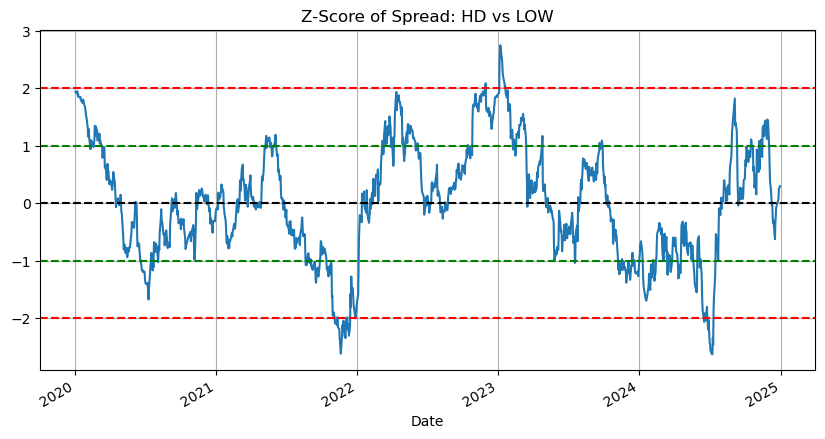

In [48]:
# Spread = HD - beta * LOW (regression hedge ratio)
beta = np.polyfit(data['BRK-B'], data['MSFT'], 1)[0]
spread = data['BRK-B'] - beta * data['MSFT']

z_score = (spread - spread.mean()) / spread.std()

# Plot Z-score
plt.figure(figsize=(10, 5))
z_score.plot()

plt.axhline(0, color='black', linestyle='--')
plt.axhline(1, color='green', linestyle='--')
plt.axhline(-1, color='green', linestyle='--')
plt.axhline(2, color='red', linestyle='--')
plt.axhline(-2, color='red', linestyle='--')
plt.title("Z-Score of Spread: HD vs LOW")
plt.grid()
plt.show()


In [ ]:
def generate_trading_signals(z_scores, entry_threshold=2, exit_threshold=0):
    signals = []
    position = 0  # 1 = long, -1 = short, 0 = flat

    for z in z_scores:
        if position == 0:
            if z > entry_threshold:
                position = -1  # short the spread
            elif z < -entry_threshold:
                position = 1   # long the spread
        elif position == 1 and z >= exit_threshold:
            position = 0  # close long
        elif position == -1 and z <= exit_threshold:
            position = 0  # close short

        signals.append(position)
    return signals

data['z_score'] = z_score
data['signal'] = generate_trading_signals(data['z_score'])

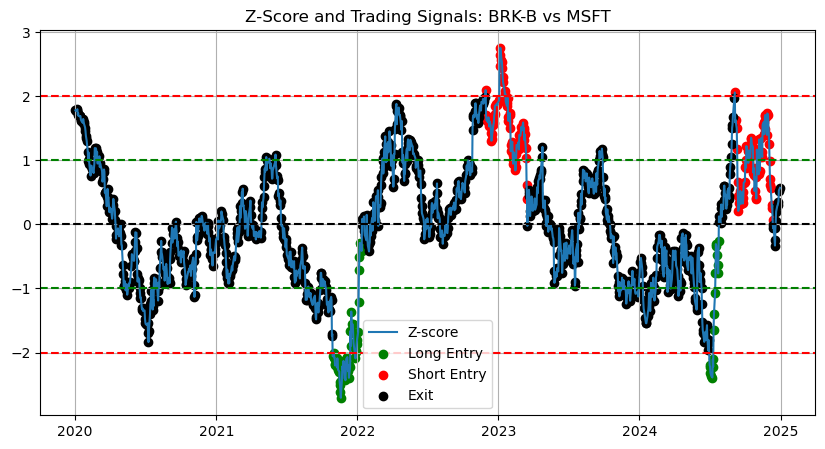

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(data.index, z_score, label='Z-score')
plt.axhline(2, color='red', linestyle='--')
plt.axhline(-2, color='red', linestyle='--')
plt.axhline(1, color='green', linestyle='--')
plt.axhline(-1, color='green', linestyle='--')
plt.axhline(0, color='black', linestyle='--')

# Highlight signal points
plt.scatter(data.index[data['signal'] == 1], z_score[data['signal'] == 1], color='green', label='Long Entry')
plt.scatter(data.index[data['signal'] == -1], z_score[data['signal'] == -1], color='red', label='Short Entry')
plt.scatter(data.index[data['signal'] == 0], z_score[data['signal'] == 0], color='black', label='Exit')

plt.title("Z-Score and Trading Signals: BRK-B vs MSFT")
plt.legend()
plt.grid()
plt.show()

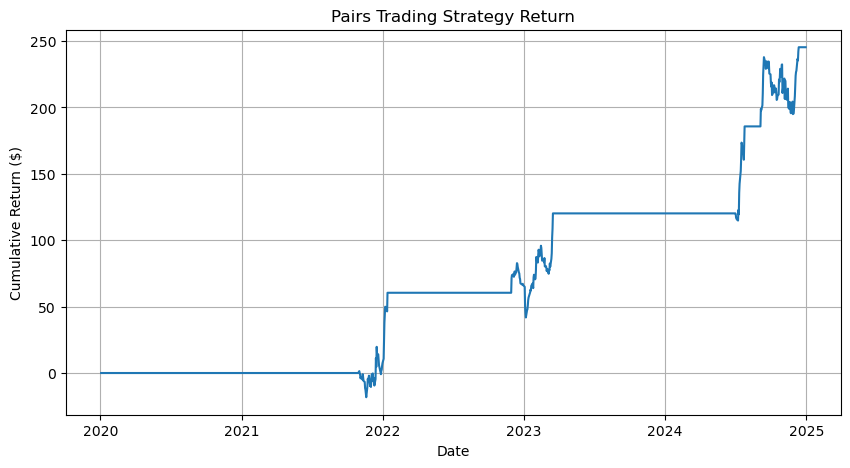

In [20]:
# Calculate daily change in the spread
data['spread_return'] = spread.diff()

# Shift trading signals by 1 day to simulate acting on signals the next day
data['position'] = data['signal'].shift(1).fillna(0)

# Compute the strategy’s daily profit or loss
data['strategy_return'] = data['position'] * data['spread_return']

# Track total cumulative return over time from the strategy
data['cumulative_return'] = data['strategy_return'].cumsum()

plt.figure(figsize=(10, 5))
plt.plot(data.index, data['cumulative_return'])
plt.title("Pairs Trading Strategy Return")
plt.xlabel("Date")
plt.ylabel("Cumulative Return ($)")
plt.grid()
plt.show()